# McNemar test for GDF+PCA+LSTM vs QUE+LOG

Null-Hypothesis: 
"Under the null hypothesis, the two algorithms should have the same error rate"

(Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithm, 1998)


If pvalue will be small we will reject that null hypothesis.


Beware - columns `TN	FN	FP	TP` are from contingency table, not from confusion table (so not for actual values). "Positives" in that case are the samples for which LSTM predicted 1.

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_lstm_predictions'
if_should_savefig = True

In [3]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    if 'mcnemar' in f:
        df_res = df_res.append(pd.read_csv(os.path.join(data_dir, f)))
df_res.index = df_res['stock']
df_res.drop(columns='Unnamed: 0', inplace=True)
df_res

,pvalue,statistic,pvalue-fisher,statistic-fisher,TN,FN,FP,TP,stock
stock,,,,,,,,,
9761,2.573863e-13,53.509187,0.162002,0.921608,1060,1043,1406,1275,9761
1431,8.239393e-14,55.747716,0.017191,1.151010,982,970,1329,1511,1431
9062,2.592082e-02,4.961293,0.174239,1.083202,1156,1121,1230,1292,9062
2822,2.357731e-03,9.247842,0.130172,0.915239,995,1141,1292,1356,2822
9058,3.796908e-01,0.771703,0.727616,0.978811,1048,1176,1220,1340,9058
3879,1.957944e-17,72.186461,0.096145,0.905907,1046,1022,1445,1279,3879
4320,3.138990e-01,1.014199,0.015947,0.869092,1002,1207,1258,1317,4320
10470,1.066029e-07,28.250214,0.189069,1.079845,1028,1040,1298,1418,10470
9061,1.069289e-05,19.383465,0.684443,0.975618,1084,1095,1312,1293,9061


In [4]:
df_res

,pvalue,statistic,pvalue-fisher,statistic-fisher,TN,FN,FP,TP,stock
stock,,,,,,,,,
9761,2.573863e-13,53.509187,0.162002,0.921608,1060,1043,1406,1275,9761
1431,8.239393e-14,55.747716,0.017191,1.151010,982,970,1329,1511,1431
9062,2.592082e-02,4.961293,0.174239,1.083202,1156,1121,1230,1292,9062
2822,2.357731e-03,9.247842,0.130172,0.915239,995,1141,1292,1356,2822
9058,3.796908e-01,0.771703,0.727616,0.978811,1048,1176,1220,1340,9058
3879,1.957944e-17,72.186461,0.096145,0.905907,1046,1022,1445,1279,3879
4320,3.138990e-01,1.014199,0.015947,0.869092,1002,1207,1258,1317,4320
10470,1.066029e-07,28.250214,0.189069,1.079845,1028,1040,1298,1418,10470
9061,1.069289e-05,19.383465,0.684443,0.975618,1084,1095,1312,1293,9061


In [5]:
df_res[df_res['pvalue'] > 0.05]

,pvalue,statistic,pvalue-fisher,statistic-fisher,TN,FN,FP,TP,stock
stock,,,,,,,,,
9058,0.379691,0.771703,0.727616,0.978811,1048,1176,1220,1340,9058
4320,0.313899,1.014199,0.015947,0.869092,1002,1207,1258,1317,4320
2730,0.092492,2.830457,0.080400,1.108779,1014,1200,1118,1467,2730
2748,0.884153,0.021231,0.359487,1.057321,885,1150,1158,1591,2748
3459,0.934993,0.006653,0.431418,0.953975,966,1205,1200,1428,3459


In [6]:
list(df_res[df_res['pvalue'] > 0.1].index)

[9058, 4320, 2748, 3459]

In [7]:
list(df_res[df_res['pvalue-fisher'] > 0.1].index)

[9761, 9062, 2822, 9058, 10470, 9061, 4799, 4851, 2748, 3459, 11583]

In [8]:
df_res[['pvalue', 'statistic']].describe()

,pvalue,statistic
count,1.500000e+01,15.000000
mean,1.768630e-01,18.824402
std,3.206039e-01,23.330439
min,1.957944e-17,0.006653
25%,5.399746e-06,1.922328
50%,2.357731e-03,9.247842
75%,2.031955e-01,23.816839
max,9.349928e-01,72.186461


In [9]:
print(df_res[['pvalue', 'statistic']].describe().to_latex())

\begin{tabular}{lrr}
\toprule
{} &        pvalue &  statistic \\
\midrule
count &  1.500000e+01 &  15.000000 \\
mean  &  1.768630e-01 &  18.824402 \\
std   &  3.206039e-01 &  23.330439 \\
min   &  1.957944e-17 &   0.006653 \\
25\%   &  5.399746e-06 &   1.922328 \\
50\%   &  2.357731e-03 &   9.247842 \\
75\%   &  2.031955e-01 &  23.816839 \\
max   &  9.349928e-01 &  72.186461 \\
\bottomrule
\end{tabular}



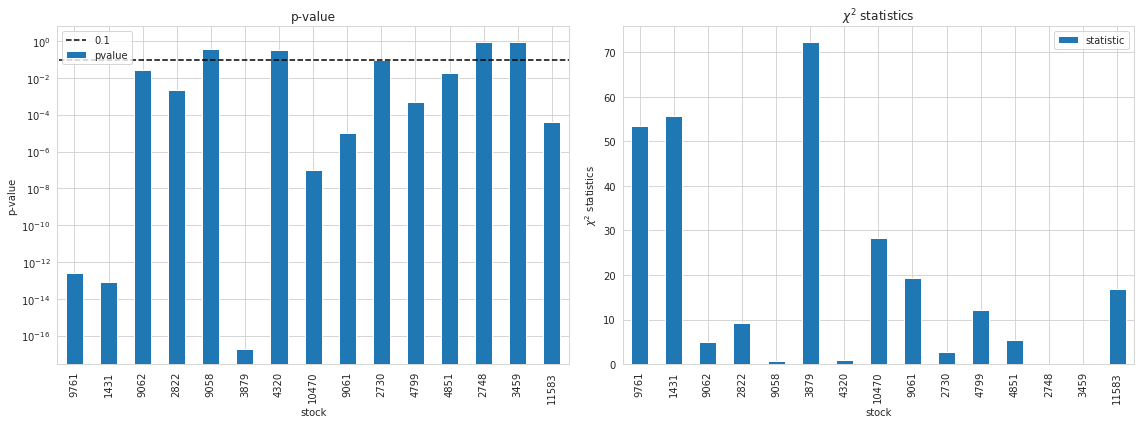

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_res[['pvalue']].plot(kind='bar', ax=ax1)
ax1.hlines(y=0.1, xmin=-10, xmax=100, linestyle='--', label='0.1')
ax1.set_title('p-value')
ax1.set_ylabel('p-value')
ax1.set_yscale('log')


ax1.legend()

df_res[['statistic']].plot(kind='bar', ax=ax2)
ax2.set_title('$\chi^2$ statistics')
ax2.set_ylabel('$\chi^2$ statistics')
ax2.legend()
plt.tight_layout()
plt.savefig('lstm_log_mcnemar.png')

## Conclusion

For all stocks p-value is really small, below $10^{-4}$. For each stock we can reject Null Hypothesis that GDF+PCA+LSTM has similar error rate as QUE+LOG.